### Unzip `brainlit/experiments/register_axons/data/mapping-files.zip` to access data used in this notebook

In [2]:
from brainlit.map_neurons.map_neurons import (
    DiffeomorphismAction,
    transform_geometricgraph,
    compute_derivs,
    CloudReg_Transform,
)
from brainlit.algorithms.trace_analysis.fit_spline import (
    GeometricGraph,
    compute_parameterization,
    CubicHermiteChain,
)
from brainlit.utils.Neuron_trace import NeuronTrace

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.interpolate import splev, splprep, CubicHermiteSpline
from scipy.spatial.distance import cosine
from scipy.stats import wilcoxon, pearsonr, linregress, norm
from tqdm import tqdm
from cloudvolume import CloudVolume
from similaritymeasures import frechet_dist
import seaborn as sns
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
from cloudvolume.exceptions import SkeletonDecodeError
import pickle
from copy import deepcopy
import networkx as nx
import os
from joblib import Parallel, delayed

In [3]:
root_dir = Path(os.path.abspath(""))
data_dir = os.path.join(root_dir, "data", "mapping-files")

## Zeroth Order Mapping Issue

Define $c: [0,1] \rightarrow \mathbb{R}^2$

In [ ]:
spacing1 = 1
spacing2 = 0.1

t1 = np.arange(0, 1 + spacing1, spacing1)
t2 = np.arange(0, 1 + spacing2, spacing2)


def c(t):
    c1 = 0 * t
    c2 = 2 * t - 1
    c = np.stack([c1, c2], axis=1)
    return c


c1 = c(t1)
c2 = c(t2)

$V:\mathbb{R}^2 \rightarrow \mathbb{R}^2$

In [ ]:
def k(x):
    k = np.exp(-(1 / (2)) * np.linalg.norm(x) ** 2)
    return k


x = np.array([[0, -1], [0, 0], [0, 1]])
y = np.array([[0, -1], [1, 0], [0, 1]])


v = y - x
K = np.zeros([x.shape[0], x.shape[0]])

for i in range(K.shape[1]):
    for j in range(K.shape[1]):
        K[i, j] = k(x[i, :] - x[j, :])

P = np.dot(np.linalg.inv(K), v)


def V(xi):
    K = np.zeros((1, x.shape[0]))
    for j in range(K.shape[1]):
        K[:, j] = k(xi - x[j, :])

    vi = np.dot(K, P)
    return np.squeeze(vi)

In [ ]:
xc, yc = np.meshgrid(np.linspace(-2, 2, 9), np.linspace(-1, 1, 9))  # 17, 9

u = 0 * xc
v = 0 * xc
for i in range(u.shape[0]):
    for j in range(u.shape[1]):
        vi = V(np.array([xc[i, j], yc[i, j]]))
        u[i, j] = vi[0]
        v[i, j] = vi[1]

$V(c(t))$

In [ ]:
Vc1 = 0 * c1

for i, ct in enumerate(c1):
    Vc1[i, :] = ct + V(ct)

Vc2 = 0 * c2

for i, ct in enumerate(c2):
    Vc2[i, :] = ct + V(ct)

In [ ]:
f, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=True, dpi=300)

headwidth = 5
fontdict = {"fontsize": 30}

ax = axs[0, 0]
ax.quiver(xc, yc, u, v, headwidth=headwidth)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# ax.set_title("a)", loc="left", fontdict=fontdict)


ax = axs[0, 1]
ax.scatter(c1[:, 0], c1[:, 1])
ax.plot(c1[:, 0], c1[:, 1])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_xlim([-2, 2])
# ax.set_title("b)", loc="left", fontdict=fontdict)


ax = axs[0, 2]
ax.scatter(Vc1[:, 0], Vc1[:, 1])
ax.plot(Vc1[:, 0], Vc1[:, 1])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_xlim([-2, 2])
# ax.set_title("c)", loc="left", fontdict=fontdict)

ax = axs[1, 0]
ax.quiver(xc, yc, u, v, headwidth=headwidth)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# ax.set_title("b)", loc="left", fontdict=fontdict)


ax = axs[1, 1]
ax.scatter(c2[:, 0], c2[:, 1])
ax.plot(c2[:, 0], c2[:, 1])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_xlim([-2, 2])
# ax.set_title("e)", loc="left", fontdict=fontdict)


ax = axs[1, 2]
ax.scatter(Vc2[:, 0], Vc2[:, 1])
ax.plot(Vc2[:, 0], Vc2[:, 1])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_xlim([-2, 2])
# ax.set_title("f)", loc="left", fontdict=fontdict)

## Toy example

In [ ]:
dict = {"x": [0, 0], "y": [-1, 1], "z": [0, 0], "sample": [1, 2], "parent": [-1, 1]}
df = pd.DataFrame(data=dict)

G = GeometricGraph(df=df)
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.fit_spline_tree_invariant(k=1)

### Custom transformation

In [ ]:
# only move points
class Triangle_0(DiffeomorphismAction):
    def __init__(self):
        pass

    def evaluate(self, position: np.array) -> np.array:
        transformed_position = position.copy()
        # if x1 between

        tophalf = np.logical_and(position[:, 1] >= 0, position[:, 1] <= 1)
        bottomhalf = np.logical_and(position[:, 1] < 0, position[:, 1] >= -1)

        newvals = position[tophalf]
        newvals[:, 0] += position[tophalf][:, 1] - 1
        transformed_position[tophalf] = newvals

        newvals = position[bottomhalf]
        newvals[:, 0] += -1 * position[bottomhalf][:, 1] - 1
        transformed_position[bottomhalf] = newvals

        return transformed_position

    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        return deriv


# move points and derivatives
class Triangle_1(Triangle_0):
    def __init__(self):
        pass

    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        transformed_deriv = deriv.copy()

        transformed_deriv[
            np.logical_and(position[:, 1] >= 0, position[:, 1] <= 1)
        ] = np.matmul(
            np.array([[1, 1, 0], [0, 1, 0], [0, 0, 1]]),
            deriv[np.logical_and(position[:, 1] >= 0, position[:, 1] <= 1)].T,
        ).T
        transformed_deriv[
            np.logical_and(position[:, 1] >= -1, position[:, 1] < 0)
        ] = np.matmul(
            np.array([[1, -1, 0], [0, 1, 0], [0, 0, 1]]),
            deriv[np.logical_and(position[:, 1] >= -1, position[:, 1] < 0)].T,
        ).T
        return transformed_deriv

In [ ]:
fig = plt.figure(figsize=(12, 24), dpi=300)
ax = fig.add_subplot(121, projection="3d")

# plot curve
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    ax.scatter(pts[0], pts[1], pts[2], c="red", s=20, label="Discrete Sampling")

    u = np.arange(u[0], u[-1] + 0.1, 0.1)
    pts = splev(u, tck)

    ax.plot(
        pts[0],
        pts[1],
        pts[2],
        linestyle="-",
        color="red",
        linewidth=0.8,
        label="Simple Curve",
    )

# plot field
diff = Triangle_0()

x, y, z = np.meshgrid(
    np.arange(-1, 0.7, 0.25), np.arange(-1, 1.2, 0.25), [np.arange(0, 1, 1)]
)  # -0.5, 0.6, 1


shp = x.shape

position = np.stack((x, y, z), axis=3)
position = np.reshape(position, [-1, 3])
transformed_position = diff.evaluate(position)
displacement = transformed_position - position
u = np.reshape(displacement[:, 0], shp)
v = np.reshape(displacement[:, 1], shp)
w = np.reshape(displacement[:, 2], shp)


ax.quiver(x, y, z, u, v, w, length=0.2, label="Scaled Displacement Field")
ax.axes.set_xlim3d(left=-1, right=0.5)
ax.axes.set_ylim3d(bottom=-1, top=1)
ax.axes.set_zlim3d(bottom=-0.5, top=0.5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)

# plt.title("Displacement Field")
plt.legend(fontsize=8)

# Transform

diff = Triangle_1()
G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, diff, deriv_method="two-sided")

ax = fig.add_subplot(122, projection="3d")

# act on dense points
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    u = np.arange(u[0], u[-1] + 0.1, 0.1)
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        linewidth=0.8,
        c="red",
        label="Continuous Mapping (Ground Truth)",
    )

    u = np.arange(u[0], u[-1] + 0.1, u[-1] - u[0])
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.scatter(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        c="red",
        s=20,
        label="Discrete Sampling",
    )
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        linewidth=0.8,
        label="Discrete Mapping - 0th Order",
        c="blue",
    )

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1] + 0.1, 0.1)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(
        pts[:, 0],
        pts[:, 1],
        pts[:, 2],
        linestyle="-",
        linewidth=0.8,
        label="Discrete Mapping - 1st Order",
        c="green",
    )
ax.axes.set_xlim3d(left=-1, right=0.5)
ax.axes.set_ylim3d(bottom=-1, top=1)
ax.axes.set_zlim3d(bottom=-0.5, top=0.5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
plt.legend(fontsize=8)
plt.show()

## Toy Example multiple segments

In [ ]:
dict = {
    "x": [0, -0.7, -1, -1],
    "y": [-1, -0.25, 0.25, 1],
    "z": [0, 0, 0.25, 1],
    "sample": [1, 2, 3, 4],
    "parent": [-1, 1, 2, 3],
}
df = pd.DataFrame(data=dict)

G = GeometricGraph(df=df)

### Gaussian warp

In [ ]:
from scipy.stats import norm


# only move points
class Gaussian_0(DiffeomorphismAction):
    def __init__(self):
        pass

    def evaluate(self, position: np.array) -> np.array:
        transformed_position = position.copy()
        transformed_position[:, 0] += norm.pdf(transformed_position[:, 1], scale=0.5)

        return transformed_position

    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        return deriv


# move points and derivatives
class Gaussian_1(Gaussian_0):
    def __init__(self):
        pass

    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        transformed_deriv = deriv.copy()
        for i, (pos, d) in enumerate(zip(position, deriv)):
            J = np.eye(3)
            J[0, 1] = norm.pdf(pos[1], scale=0.5) * (-4 * pos[1])
            transformed_deriv[i, :] = np.matmul(J, d).T

        return transformed_deriv

In [ ]:
from re import T

fig = plt.figure(figsize=(12, 24), dpi=300)
ax = fig.add_subplot(121, projection="3d")

soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.fit_spline_tree_invariant(k=1)
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    pts = splev(u, tck)
    ax.plot(
        pts[0],
        pts[1],
        pts[2],
        linestyle="-",
        linewidth=0.8,
        label="Simple Curve",
        c="red",
    )
    ax.scatter(pts[0], pts[1], pts[2], c="red")

    u = np.arange(u[0], u[-1] + 0.01, 0.01)
    pts = splev(u, tck)

    # ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="spline")
# ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)

# Generate transformation
diff = Gaussian_0()

x, y, z = np.meshgrid(np.arange(-1, 0.4, 0.25), np.arange(-1, 1.2, 0.25), [0.5])


shp = x.shape

position = np.stack((x, y, z), axis=3)
position = np.reshape(position, [-1, 3])
transformed_position = diff.evaluate(position)
displacement = transformed_position - position
u = np.reshape(displacement[:, 0], shp)
v = np.reshape(displacement[:, 1], shp)
w = np.reshape(displacement[:, 2], shp)

ax.quiver(x, y, z, u, v, w, length=0.2, label="Scaled Displacement Field")

ax.legend(fontsize=8)
ax.axes.set_xlim3d(left=-1, right=0.25)
ax.axes.set_ylim3d(bottom=-1, top=1)
ax.axes.set_zlim3d(bottom=0, top=1)
# ax.set_title("c)", loc="left", fontdict={"fontsize": 20})

# Transform

diff = Gaussian_1()
G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, diff, deriv_method="two-sided")

ax = fig.add_subplot(122, projection="3d")

# act on dense points
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    tck[2] = 1

    # dense spline points
    u = np.arange(u[0], u[-1] + 0.005, 0.01)
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        linewidth=0.8,
        label="Continuous Mapping (Ground Truth)",
        c="red",
    )

    # trace points only
    u = spline[1]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        linewidth=0.8,
        label="Discrete Mapping - 0th Order",
        c="blue",
    )
    ax.scatter(trans_pts[:, 0], trans_pts[:, 1], trans_pts[:, 2], c="red")

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1] + 0.005, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(
        pts[:, 0],
        pts[:, 1],
        pts[:, 2],
        linestyle="-",
        linewidth=0.8,
        label="Discrete Mapping - 1st Order",
        c="green",
    )

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
plt.legend(fontsize=8)
ax.axes.set_xlim3d(left=-1, right=0.25)
ax.axes.set_ylim3d(bottom=-1, top=1)
ax.axes.set_zlim3d(bottom=0, top=1)
# ax.set_title("d)", loc="left", fontdict={"fontsize": 20})
plt.show()

## Downsample swirl

In [ ]:
t = np.arange(0, 6 * np.pi, 0.1)

x = 0.05 * t * np.cos(t) - 0.5
y = 0.05 * t * np.sin(t)
z = 0 * t + 0.5

dict = {
    "x": x,
    "y": y,
    "z": z,
    "sample": [i for i in range(len(t))],
    "parent": [-1] + [i for i in range(len(t) - 1)],
}
df = pd.DataFrame(data=dict)

G = GeometricGraph(df=df, root=0)

# identify which nodes to keep/remove
nodes2keep = [i for i in range(0, len(t), 5)]
if len(t) - 1 not in nodes2keep:
    nodes2keep += [len(t) - 1]
print(f"nodes to keep: {nodes2keep}")
nodes2remove = [i for i in range(len(t)) if i not in nodes2keep]
print(f"nodes to remove: {nodes2remove}")
G.fit_spline_tree_invariant()
spline_tree = G.spline_tree

In [ ]:
# only move points
class Gaussian_0(DiffeomorphismAction):
    def __init__(self):
        pass

    def evaluate(self, position: np.array) -> np.array:
        transformed_position = position.copy()
        transformed_position[:, 0] += norm.pdf(transformed_position[:, 1], scale=0.5)

        return transformed_position

    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        return deriv


# move points and derivatives
class Gaussian_1(Gaussian_0):
    def __init__(self):
        pass

    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        transformed_deriv = deriv.copy()
        for i, (pos, d) in enumerate(zip(position, deriv)):
            J = np.eye(3)
            J[0, 1] = norm.pdf(pos[1], scale=0.5) * (-4 * pos[1])
            transformed_deriv[i, :] = np.matmul(J, d).T

        return transformed_deriv

In [ ]:
path = spline_tree.nodes[0]["path"]
tck, us = spline_tree.nodes[0]["spline"]
positions = np.array(splev(us, tck, der=0)).T
derivs = compute_derivs(
    us=us, positions=positions
)  # estimate derivatives for use in 1st order mapping

In [ ]:
H = deepcopy(G)

H.remove_nodes_from(nodes2remove)
H.remove_edges_from(list(G.edges))

for node1, node2 in zip(nodes2keep[:-1], nodes2keep[1:]):
    H.add_edge(node1, node2)


derivs = np.delete(derivs, nodes2remove, 0)
left_derivs = derivs[:-1, :]
right_derivs = derivs[1:, :]
derivs = (left_derivs, right_derivs)

H.fit_spline_tree_invariant(k=1)

In [ ]:
diff = Gaussian_1()
G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, diff, deriv_method="two-sided")
H_transformed = deepcopy(H)
H_transformed = transform_geometricgraph(
    H_transformed, diff, deriv_method="two-sided", derivs=derivs
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10), dpi=300)

## Before
ax = ax1

soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.fit_spline_tree_invariant(k=1)
for node in tqdm(spline_tree.nodes, desc="Processing branches"):
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    pts = splev(u, tck)
    ax.plot(pts[0], pts[1], linestyle="-", linewidth=0.8, label="Simple Curve", c="red")

    u = np.arange(u[0], u[-1] + 0.01, 0.01)
    pts = splev(u, tck)

xs_ds = []
ys_ds = []
for node2keep in nodes2keep:
    xs_ds.append(G.nodes[node2keep]["loc"][0])
    ys_ds.append(G.nodes[node2keep]["loc"][1])
ax.scatter(xs_ds, ys_ds, c="blue", label="Discrete Sampling")

ax.grid(True)

# Generate transformation
diff = Gaussian_0()

x, y, z = np.meshgrid(np.arange(-1.25, 0.4, 0.25), np.arange(-1, 1.2, 0.25), [0.5])


shp = x.shape

position = np.stack((x, y, z), axis=3)
position = np.reshape(position, [-1, 3])
transformed_position = diff.evaluate(position)
displacement = transformed_position - position
u = np.reshape(displacement[:, 0], shp)
v = np.reshape(displacement[:, 1], shp)
w = np.reshape(displacement[:, 2], shp)


ax.quiver(
    np.squeeze(x),
    np.squeeze(y),
    np.squeeze(u),
    np.squeeze(v),
    color="green",
    label="Scaled Displacement Field",
)

ax.legend(fontsize=17)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# ax.set_title("e)", loc="left", fontdict={"fontsize": 20})


## After
ax = ax2

# act on dense points
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # knots only
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)

    # dense spline points
    u = np.arange(u[0], u[-1] + 0.005, 0.01)
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        linestyle="-",
        linewidth=0.8,
        label="Continuous Mapping (Ground Truth)",
        c="red",
    )

# act on dense points
soma = np.array(H_transformed.nodes[H_transformed.root]["loc"])
spline_tree = H.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    u = spline[1]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        linestyle="-",
        linewidth=0.8,
        label="Discrete Mapping - 0th Order",
        c="blue",
    )
    ax.scatter(trans_pts[:, 0], trans_pts[:, 1], c="blue")

# act on derivatives
soma = np.array(H_transformed.nodes[H_transformed.root]["loc"])
spline_tree = H_transformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1] + 0.005, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(
        pts[:, 0],
        pts[:, 1],
        linestyle="-",
        linewidth=0.8,
        label="Discrete Mapping - 1st Order",
        c="green",
    )


ax.grid(True)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# ax.set_title("f)", loc="left", fontdict={"fontsize": 20})
plt.legend(fontsize=17)
plt.show()

## Downsample Tree

In [ ]:
t1 = np.arange(-1, 1.01, 0.01)
x1 = 0 * t1 - 0.5
y1 = t1
z1 = 0 * t1
p1 = [-1] + [i for i in range(len(t1) - 1)]
s1 = [i for i in range(len(t1))]
dict = {"x": x1, "y": y1, "z": z1, "sample": s1, "parent": p1}
df = pd.DataFrame(data=dict)
G1 = GeometricGraph(df=df, root=0)
nodes2keep1 = [0, 30, 60, 90, 100, 130, 150, 180]
nodes2keep1 += [len(t1) - 1]
nodes2remove1 = [i for i in range(len(t1)) if i not in nodes2keep1]
G1.fit_spline_tree_invariant()

t2 = np.arange(0, 0.9, 0.01)
x2 = t2 - 0.5
y2 = t2**2
z2 = 0 * t2
p2 = [-1] + [i for i in range(len(t2) - 1)]
s2 = [i for i in range(len(t2))]
dict = {"x": x2, "y": y2, "z": z2, "sample": s2, "parent": p2}
df = pd.DataFrame(data=dict)
G2 = GeometricGraph(df=df, root=0)
nodes2keep2 = [0, 30, 60]
nodes2keep2 += [len(t2) - 1]
nodes2remove2 = [i for i in range(len(t2)) if i not in nodes2keep2]
G2.fit_spline_tree_invariant()

t3 = np.arange(0, 0.5, 0.01)
x3 = -t3 - 0.5
y3 = 0.5 + 0.5 * np.sqrt(t3)
z3 = 0 * t3
p3 = [-1] + [i for i in range(len(t3) - 1)]
s3 = [i for i in range(len(t3))]
dict = {"x": x3, "y": y3, "z": z3, "sample": s3, "parent": p3}
df = pd.DataFrame(data=dict)
G3 = GeometricGraph(df=df, root=0)
nodes2keep3 = [0, 30]
nodes2keep3 += [len(t3) - 1]
nodes2remove3 = [i for i in range(len(t3)) if i not in nodes2keep3]
G3.fit_spline_tree_invariant()

In [ ]:
class Rotate(DiffeomorphismAction):
    def __init__(self):
        pass

    def evaluate(self, position: np.array) -> np.array:
        theta = np.arctan2(position[:, 1], position[:, 0])
        r = np.linalg.norm(position, axis=1)

        transformed_position = position.copy()
        transformed_position[:, 0] = np.multiply(r, np.cos(theta + r))
        transformed_position[:, 1] = np.multiply(r, np.sin(theta + r))

        return transformed_position

    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        transformed_deriv = deriv.copy()
        for i, (pos, d) in enumerate(zip(position, deriv)):
            J = np.eye(3)

            x = pos[0]
            y = pos[1]
            r = np.linalg.norm(pos)
            theta = np.arctan2(pos[1], pos[0])

            if r > 0:
                J[0, 0] = x / r * np.cos(theta + r) - r * np.sin(theta + r) * (
                    x / r - y / (x**2 + y**2)
                )
                J[0, 1] = y / r * np.cos(theta + r) - r * np.sin(theta + r) * (
                    y / r + x / (x**2 + y**2)
                )

                J[1, 0] = x / r * np.sin(theta + r) + r * np.cos(theta + r) * (
                    x / r - y / (x**2 + y**2)
                )
                J[1, 1] = y / r * np.sin(theta + r) + r * np.cos(theta + r) * (
                    y / r + x / (x**2 + y**2)
                )

            transformed_deriv[i, :] = np.matmul(J, d).T

        return transformed_deriv

In [ ]:
H_transformeds = []
Hs = []

for G, nodes2keep, nodes2remove in zip(
    [G1, G2, G3],
    [nodes2keep1, nodes2keep2, nodes2keep3],
    [nodes2remove1, nodes2remove2, nodes2remove3],
):
    spline_tree = G.spline_tree
    path = spline_tree.nodes[0]["path"]
    tck, us = spline_tree.nodes[0]["spline"]
    positions = np.array(splev(us, tck, der=0)).T
    derivs = compute_derivs(us=us, positions=positions)

    H = deepcopy(G)

    H.remove_nodes_from(nodes2remove)
    H.remove_edges_from(list(G.edges))

    for node1, node2 in zip(nodes2keep[:-1], nodes2keep[1:]):
        H.add_edge(node1, node2)

    derivs = np.delete(derivs, nodes2remove, 0)
    left_derivs = derivs[:-1, :]
    right_derivs = derivs[1:, :]
    derivs = (left_derivs, right_derivs)

    H.fit_spline_tree_invariant(k=1)

    diff = Rotate()
    G_transformed = deepcopy(G)
    G_transformed = transform_geometricgraph(
        G_transformed, diff, deriv_method="two-sided"
    )
    H_transformed = deepcopy(H)
    H_transformed = transform_geometricgraph(
        H_transformed, diff, deriv_method="two-sided", derivs=derivs
    )
    H_transformeds.append(H_transformed)
    Hs.append(H)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10), dpi=300)

## Before
ax = ax1

for b, G in enumerate([G1, G2, G3]):
    spline_tree = G.fit_spline_tree_invariant(k=1)
    spline = spline_tree.nodes[0]["spline"]
    u = spline[1]
    tck = spline[0]

    pts = splev(u, tck)
    if b == 0:
        label = "Simple Curve"
    else:
        label = None
    ax.plot(pts[0], pts[1], linestyle="-", linewidth=0.8, c="red", label=label)

    u = np.arange(u[0], u[-1] + 0.01, 0.01)
    pts = splev(u, tck)


xs_ds = []
ys_ds = []
for G, nodes2keep in zip([G1, G2, G3], [nodes2keep1, nodes2keep2, nodes2keep3]):
    for node2keep in nodes2keep:
        xs_ds.append(G.nodes[node2keep]["loc"][0])
        ys_ds.append(G.nodes[node2keep]["loc"][1])
ax.scatter(xs_ds, ys_ds, c="blue", label="Discrete Sampling")

ax.grid(True)

# Generate transformation
diff = Rotate()

x, y, z = np.meshgrid(np.arange(-1.25, 0.4, 0.25), np.arange(-1, 1.2, 0.25), [0.5])

shp = x.shape

position = np.stack((x, y, z), axis=3)
position = np.reshape(position, [-1, 3])
transformed_position = diff.evaluate(position)
displacement = transformed_position - position
u = np.reshape(displacement[:, 0], shp)
v = np.reshape(displacement[:, 1], shp)
w = np.reshape(displacement[:, 2], shp)


ax.quiver(
    np.squeeze(x),
    np.squeeze(y),
    np.squeeze(u),
    np.squeeze(v),
    color="green",
    label="Scaled Displacement Field",
)

ax.legend(fontsize=17)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# ax.set_title("g)", loc="left", fontdict={"fontsize": 20})


## After

ax = ax2

for b, (G, H_transformed, H) in enumerate(zip([G1, G2, G3], H_transformeds, Hs)):
    if b == 0:
        lbl1 = "Continuous Mapping (Ground Truth)"
        lbl2 = "Discrete Mapping - 0th Order"
        lbl3 = "Discrete Mapping - 1st Order"
    else:
        lbl1 = None
        lbl2 = None
        lbl3 = None
    # act on dense points
    spline_tree = G.spline_tree
    for node in spline_tree.nodes:
        spline = spline_tree.nodes[node]["spline"]
        u = spline[1]
        tck = spline[0]

        # knots only
        pts = splev(u, tck)
        pts = np.stack(pts, axis=1)
        trans_pts = diff.evaluate(pts)

        # dense spline points
        u = np.arange(u[0], u[-1] + 0.005, 0.01)
        pts = splev(u, tck)
        pts = np.stack(pts, axis=1)
        trans_pts = diff.evaluate(pts)
        ax.plot(
            trans_pts[:, 0],
            trans_pts[:, 1],
            linestyle="-",
            linewidth=0.8,
            label=lbl1,
            c="red",
        )

    # act on dense points
    soma = np.array(H_transformed.nodes[H_transformed.root]["loc"])
    spline_tree = H.spline_tree
    for node in spline_tree.nodes:
        spline = spline_tree.nodes[node]["spline"]
        u = spline[1]
        tck = spline[0]

        # trace points only
        u = spline[1]
        pts = splev(u, tck)
        pts = np.stack(pts, axis=1)
        trans_pts = diff.evaluate(pts)
        ax.plot(
            trans_pts[:, 0],
            trans_pts[:, 1],
            linestyle="-",
            linewidth=0.8,
            label=lbl2,
            c="blue",
        )
        ax.scatter(trans_pts[:, 0], trans_pts[:, 1], c="blue")

    # act on derivatives
    soma = np.array(H_transformed.nodes[H_transformed.root]["loc"])
    spline_tree = H_transformed.spline_tree
    for node in spline_tree.nodes:
        spline = spline_tree.nodes[node]["spline"]
        u = spline[1]
        u = np.arange(u[0], u[-1] + 0.005, 0.01)
        chspline = spline[0]
        pts = chspline(u)

        ax.plot(
            pts[:, 0], pts[:, 1], linestyle="-", linewidth=0.8, label=lbl3, c="green"
        )


ax.grid(True)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# ax.set_title("h)", loc="left", fontdict={"fontsize": 20})
plt.legend(fontsize=17)
plt.show()

##  CloudReg + Real Neuron

In [ ]:
velocity_path = os.path.join(data_dir, "downloop_1_v.mat")
affine_path = os.path.join(data_dir, "downloop_1_A.mat")

ct = CloudReg_Transform(velocity_path, affine_path)

### Plot Registration Transformation

In [ ]:
og_coords = ct.og_coords

xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.axes(projection="3d")

ax.scatter3D(
    og_coords[:, 0], og_coords[:, 1], og_coords[:, 2], label="Sample Space Grid"
)

ax = fig.gca(projection="3d")
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    np.ones((og_coords.shape[0])),
    np.ones((og_coords.shape[0])),
    np.ones((og_coords.shape[0])),
    length=500,
    label="Sample Space Tangents",
    alpha=0.5,
)

new_coords = ct.evaluate(og_coords)
print(
    f"average squared deformation {np.sum((og_coords-new_coords)**2)/og_coords.shape[0]}"
)
new_derivs = ct.D(og_coords, np.ones(og_coords.shape))
cosines = []
for new_deriv in new_derivs:
    sn = cosine(new_deriv, [1, 1, 1])
    cosines.append(sn)
print(f"average 1-cosine between derivatives {np.mean(cosines)}")

ax.scatter3D(
    new_coords[:, 0],
    new_coords[:, 1],
    new_coords[:, 2],
    label="Transformed Grid",
    color="red",
)
ax.quiver(
    new_coords[:, 0],
    new_coords[:, 1],
    new_coords[:, 2],
    new_derivs[:, 0],
    new_derivs[:, 1],
    new_derivs[:, 2],
    length=500,
    color="red",
    label="Transformed Tangents",
    alpha=0.5,
)
# ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], new_coords[:,0]-og_coords[:,0],new_coords[:,1]-og_coords[:,1],new_coords[:,2]-og_coords[:,2], length=20, color='blue', label="Scaled Displacement Field")
ax.legend(fontsize=17)

In [ ]:
fig, axs = plt.subplots(2, dpi=300)
position_diff = np.linalg.norm(og_coords - new_coords, axis=1)
deriv_diff = np.linalg.norm(np.ones(og_coords.shape) - new_derivs, axis=1)
data = {
    "Displacement at Grid Points (microns)": position_diff,
    "Tangent Vector Displacement at Grid Points": deriv_diff,
}
df = pd.DataFrame(data=data)
sns.histplot(data=df, ax=axs[0], x="Displacement at Grid Points (microns)")
sns.histplot(data=df, ax=axs[1], x="Tangent Vector Displacement at Grid Points")
plt.tight_layout()

### Plot Neuron Branch Transformation

In [ ]:
# 1,22; 4,179
neuron_id = 4
branch_id = 179

im_path = "precomputed://file://" + os.path.join(data_dir, "ch1_otsu_iso")
vol_im = CloudVolume(im_path)
shp = np.array(vol_im.shape)
res_im = np.array(vol_im.resolution) / 1000
origin_im = (shp[:3] - 1) * res_im / 2

axons_path = "precomputed://file://" + os.path.join(data_dir, "axons")
vol = CloudVolume(axons_path)
shp = np.array(vol.shape)
res_atlas = np.array(vol.resolution) / 1000
origin_atlas = (shp[:3] - 1) * res_atlas / 2

# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices / 1000 - origin_im

# apply affine transform
coords = ct.apply_affine(coords)

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
for edge in skel.edges:
    G.add_edge(edge[0], edge[1])

spline_tree = G.fit_spline_tree_invariant()

# Target space

fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 2, 1, projection="3d")

G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, ct, deriv_method="two-sided")
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    if i == 0 or node == branch_id:
        label = "Neuron Branch"
    else:
        label = None
    ax.plot(pts[0], pts[1], pts[2], linestyle="-", label=label, color="red")
    derivs = splev(u, tck, der=1)

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    length=7,
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.legend(fontsize=12)


ax = fig.add_subplot(1, 2, 2, projection="3d")

spline = spline_tree.nodes[branch_id]["spline"]
u = spline[1]
tck = spline[0]
pts = splev(u, tck)
pts = np.stack(pts, axis=1)


# dense line points
tck_line, u_line = splprep(pts.T, k=1, s=0)
u_line = np.arange(u_line[0], u_line[-1] + 0.01, 0.01)
pts_line = splev(u_line, tck_line)
pts_line = np.stack(pts_line, axis=1)
trans_pts = ct.evaluate(pts_line)

label = "Continuous Mapping (Ground Truth)"
ax.plot(
    trans_pts[:, 0],
    trans_pts[:, 1],
    trans_pts[:, 2],
    linestyle="-",
    color="red",
    label=label,
)

# Transformed points
trans_pts = ct.evaluate(pts)
label = "Discrete Mapping - 0th Order"
ax.plot(
    trans_pts[:, 0],
    trans_pts[:, 1],
    trans_pts[:, 2],
    linestyle="-",
    label=label,
    color="blue",
    alpha=0.5,
)
derivs = splev(u, tck, der=1)
derivs = np.stack(derivs, axis=1)
trans_derivs = ct.D(pts, derivs)

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree

spline = spline_tree.nodes[branch_id]["spline"]
u = spline[1]
u = np.arange(u[0], u[-1] + 0.01, 0.01)
chspline = spline[0]
pts = chspline(u)

label = "Discrete Mapping - 1st Order"
ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], linestyle="-", label=label, color="green")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)

plt.show()

### Plot Whole Neuron Transformation

In [ ]:
# 1,22; 4,179
neuron_id = 1
branch_id = -1

# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices / 1000 - origin_im

# apply affine transform
coords = ct.apply_affine(coords)

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
for edge in skel.edges:
    G.add_edge(edge[0], edge[1])

spline_tree = G.fit_spline_tree_invariant()

# Target space

fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 2, 1, projection="3d")

G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, ct, deriv_method="two-sided")
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    if i == 0 or node == branch_id:
        label = "Neuron Branch"
    else:
        label = None
    ax.plot(pts[0], pts[1], pts[2], linestyle="-", label=label, color="red")
    derivs = splev(u, tck, der=1)

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    length=20,
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.legend(fontsize=12)


ax = fig.add_subplot(1, 2, 2, projection="3d")

for i, node in enumerate(tqdm(spline_tree.nodes, desc="0th order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)

    # dense line points
    tck_line, u_line = splprep(pts.T, k=1, s=0)
    u_line = np.arange(u_line[0], u_line[-1] + 0.01, 0.01)
    pts_line = splev(u_line, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    trans_pts = ct.evaluate(pts_line)
    if i == 0 or node == branch_id:
        label = "Continuous Mapping (Ground Truth)"
    else:
        label = None
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        color="red",
        label=label,
    )

    # Transformed points
    trans_pts = ct.evaluate(pts)
    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 0th Order"
    else:
        label = None
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        label=label,
        color="blue",
        alpha=0.5,
    )
    derivs = splev(u, tck, der=1)
    derivs = np.stack(derivs, axis=1)
    trans_derivs = ct.D(pts, derivs)

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree
for i, node in enumerate(tqdm(spline_tree.nodes, desc="1st order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1] + 0.01, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 1st Order"
    else:
        label = None
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], linestyle="-", label=label, color="green")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)

plt.show()

## Downsample Neuron Phenomena

In [ ]:
im_path = "precomputed://file://" + os.path.join(data_dir, "ch1_otsu_iso")
vol_im = CloudVolume(im_path)
shp = np.array(vol_im.shape)
res_im = np.array(vol_im.resolution) / 1000
origin_im = (shp[:3] - 1) * res_im / 2

axons_path = "precomputed://file://" + os.path.join(data_dir, "axons")
vol = CloudVolume(axons_path)
shp = np.array(vol.shape)
res_im = np.array(vol.resolution) / 1000
origin_im = (shp[:3] - 1) * res_im / 2

valid_ids = []
for i in range(100):
    try:
        vol.skeleton.get(i)
    except SkeletonDecodeError:
        continue
    valid_ids.append(i)

print(f"Valid IDs: {valid_ids}")

velocity_path = os.path.join(data_dir, "downloop_1_v.mat")
affine_path = os.path.join(data_dir, "downloop_1_A.mat")
ct = CloudReg_Transform(
    "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/precomputed_ch1_otsu_iso_registration/downloop_1_v.mat",
    "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/precomputed_ch1_otsu_iso_registration/downloop_1_A.mat",
)

In [ ]:
methods = []
errors = []
av_sample_distances = []

spacing = 2
inter = 65
ds_factor = 100

### No Downsampling

In [ ]:
# 1,22; 4,179
# 12, 203; 12,315; 20,160;20,2644
neuron_id = 12
branch_id = 203  # 203, 315

# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices / 1000 - origin_im

# apply affine transform
coords = ct.apply_affine(coords)

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
for edge in skel.edges:
    G.add_edge(edge[0], edge[1])

spline_tree = G.fit_spline_tree_invariant()

# Target space
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 2, 1, projection="3d")

G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, ct, deriv_method="two-sided")
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    if i == 0 or node == branch_id:
        label = "Neuron Branch"
    else:
        label = None
    ax.plot(pts[0], pts[1], pts[2], linestyle="-", label=label, color="red")
    ax.scatter(
        pts[0], pts[1], pts[2], linestyle="-", label="Discrete Sampling", color="blue"
    )
    derivs = splev(u, tck, der=1)

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    length=3,
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.legend(fontsize=12)

ax = fig.add_subplot(1, 2, 2, projection="3d")

for i, node in enumerate(tqdm(spline_tree.nodes, desc="0th order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)

    # dense line points
    tck_line, u_line = splprep(pts.T, k=1, s=0)
    u_line = np.arange(u_line[0], u_line[-1] + 0.01, 0.01)
    pts_line = splev(u_line, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    trans_pts = ct.evaluate(pts_line)
    if i == 0 or node == branch_id:
        label = "Continuous Mapping (Ground Truth)"
    else:
        label = None
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        color="red",
        label=label,
    )

    # Transformed points
    trans_pts = ct.evaluate(pts)
    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 0th Order"
    else:
        label = None
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        label=label,
        color="blue",
        alpha=0.5,
    )
    ax.scatter(trans_pts[:, 0], trans_pts[:, 1], trans_pts[:, 2], color="blue")
    derivs = splev(u, tck, der=1)
    derivs = np.stack(derivs, axis=1)
    trans_derivs = ct.D(pts, derivs)

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree
for i, node in enumerate(tqdm(spline_tree.nodes, desc="1st order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1] + 0.01, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 1st Order"
    else:
        label = None
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], linestyle="-", label=label, color="green")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)

plt.show()

### 100x Downsampling

In [ ]:
neuron_id = 12
branch_id = 203  # 203, 315


# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices / 1000 - origin_im

# apply affine transform
coords = ct.apply_affine(coords)

G_neuron = GeometricGraph()
for node_id, coord in enumerate(coords):
    G_neuron.add_node(node_id, loc=coord)
for edge in skel.edges:
    G_neuron.add_edge(edge[0], edge[1])

if id == 20:
    G_neuron.remove_node(4957)
    G_neuron.add_edge(4956, 4958)
if id == 53:
    G_neuron.remove_node(0)

spline_tree = G_neuron.fit_spline_tree_invariant()


path = spline_tree.nodes[branch_id]["path"]
x = []
y = []
z = []
s = []
p = [-1]

for node_i, node in enumerate(path):
    loc = G_neuron.nodes[node]["loc"]
    x.append(loc[0])
    y.append(loc[1])
    z.append(loc[2])
    s.append(node_i)
    if node_i > 0:
        p.append(node_i - 1)


dict = {"x": x, "y": y, "z": z, "sample": s, "parent": p}
df = pd.DataFrame(data=dict)
G_branch = GeometricGraph(df=df, root=s[0])
G_branch.fit_spline_tree_invariant()
spline_tree_branch = G_branch.spline_tree

# downsample
nodes2keep = [node_i for node_i in range(0, len(s), ds_factor)]
if s[-1] not in nodes2keep:
    nodes2keep += [s[-1]]
nodes2remove = [node_i for node_i in s if node_i not in nodes2keep]

path = spline_tree_branch.nodes[0]["path"]
tck, us = spline_tree_branch.nodes[0]["spline"]
positions = np.array(splev(us, tck, der=0)).T
derivs = compute_derivs(us=us, positions=positions)

G_branch_ds = deepcopy(G_branch)
G_branch_ds.remove_nodes_from(nodes2remove)
G_branch_ds.remove_edges_from(list(G_branch.edges))
for node1, node2 in zip(nodes2keep[:-1], nodes2keep[1:]):
    G_branch_ds.add_edge(node1, node2)
derivs = np.delete(derivs, nodes2remove, 0)
G_branch_ds.fit_spline_tree_invariant(k=1)
spline_tree_branch_ds = G_branch_ds.spline_tree

# transform the branch
G_branch_transformed = deepcopy(G_branch)
G_branch_ds_transformed = deepcopy(G_branch_ds)
G_branch_ds_transformed = transform_geometricgraph(
    G_branch_ds_transformed, ct, deriv_method="two-sided"
)

spline_tree_transformed = G_branch_transformed.spline_tree
spline_tree_transformed_ds = G_branch_ds_transformed.spline_tree

if len(spline_tree_transformed_ds.nodes) != 1:
    raise ValueError("transformed spline tree does not have 1 branch")

# Compute sampling length from downsampled branch
spline = spline_tree_branch_ds.nodes[0]["spline"]
u = spline[1]
tck = spline[0]
pts = splev(u, tck)
pts = np.stack(pts, axis=1)
av_sample_distance = np.mean(np.linalg.norm(np.diff(pts, axis=0), axis=1))

# Access original knots and compute sample distance
spline = spline_tree_branch_ds.nodes[0]["spline"]
u = spline[1]
tck = spline[0]
pts = splev(u, tck)
pts = np.stack(pts, axis=1)

# Find dense line points
tck_line, _ = splprep(pts.T, k=1, s=0, u=u)
u_dense = np.arange(u[0], u[-1], spacing)
u_dense = np.append(u_dense, u[-1])
pts_line = splev(u_dense, tck_line)
pts_line = np.stack(pts_line, axis=1)
dense_line_pts = ct.evaluate(pts_line)

# Find transformed knots
spline = spline_tree_transformed_ds.nodes[0]["spline"]
chspline = spline[0]
u = spline[1]
u_first_order = np.arange(u[0], u[-1], spacing)
u_first_order = np.append(u_first_order, u[-1])
trans_pts = chspline(u)

# print("0th Order Mapping...")
u_line = compute_parameterization(trans_pts)
tck_line, u_line = splprep(trans_pts.T, k=1, s=0, u=u_line)
u_line = np.arange(u_line[0], u_line[-1], spacing)
u_line = np.append(u_line, u[-1])
zero_order_pts = splev(u_line, tck_line)
zero_order_pts = np.stack(zero_order_pts, axis=1)

# print("1st order mapping...")
first_order_pts = chspline(u_first_order)

for method, method_pts in zip(
    ["Zeroth Order", "First Order"], [zero_order_pts, first_order_pts]
):
    error = frechet_dist(dense_line_pts, method_pts)

    av_sample_distances.append(av_sample_distance)
    errors.append(error)
    methods.append(method)
    print(f"{method} error: {error} with av sample dist: {av_sample_distance}")

### Plot

In [ ]:
azim = 220
a = 350
b = 450

# Target soace
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 3, 1, projection="3d")
ax.plot(
    pts[:, 0], pts[:, 1], pts[:, 2], linestyle="-", label="Neuron Branch", color="red"
)


spline = G_branch_ds.spline_tree.nodes[0]["spline"]
u = spline[1]
tck = spline[0]
pts_ds = splev(u, tck)
pts_ds = np.stack(pts_ds, axis=1)
ax.scatter(
    pts_ds[:, 0], pts_ds[:, 1], pts_ds[:, 2], label="Downsampled Knots", color="blue"
)
print(pts_ds)
xmin_ex, xmax_ex = np.amin(pts_ds[:2,0]), np.amax(pts_ds[:2,0])
ymin_ex, ymax_ex = np.amin(pts_ds[:2,1]), np.amax(pts_ds[:2,1])
zmin_ex, zmax_ex = np.amin(pts_ds[:2,2]), np.amax(pts_ds[:2,2])
gap = np.linalg.norm(pts_ds[0,:]-pts_ds[1,:])
print(f"Distance bw first two knots: {gap}")
d1 = np.linalg.norm(pts_ds[0,:]-trans_pts[0,:])
d2 = np.linalg.norm(pts_ds[1,:]-trans_pts[1,:])
dsum = np.linalg.norm((pts_ds[0,:]-trans_pts[0,:])-(pts_ds[1,:]-trans_pts[1,:]))
print(f"Displacement distances: {d1}, {d2} orsum {dsum}")

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    length=3,
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.legend(fontsize=12)
ax.view_init(elev=20, azim=azim)

ax = fig.add_subplot(1, 3, 2, projection="3d")
ax.plot(
    dense_line_pts[:, 0],
    dense_line_pts[:, 1],
    dense_line_pts[:, 2],
    c="red",
    label="Continuous Mapping (Ground Truth)",
    alpha=0.5,
)
ax.plot(
    zero_order_pts[:, 0],
    zero_order_pts[:, 1],
    zero_order_pts[:, 2],
    c="blue",
    label="Discrete Mapping - 0th Order",
    linestyle="--",
)
ax.scatter(trans_pts[:, 0], trans_pts[:, 1], trans_pts[:, 2], c="blue")
ax.plot(
    first_order_pts[:, 0],
    first_order_pts[:, 1],
    first_order_pts[:, 2],
    c="green",
    label="Discrete Mapping - 1st Order",
    linestyle="--",
)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)
ax.view_init(elev=20, azim=azim)


ax = fig.add_subplot(1, 3, 3, projection="3d")
ax.plot(
    dense_line_pts[a:b, 0],
    dense_line_pts[a:b, 1],
    dense_line_pts[a:b, 2],
    c="red",
    label="Continuous Mapping (Ground Truth)",
    alpha=0.5,
)
ax.plot(
    zero_order_pts[a:b, 0],
    zero_order_pts[a:b, 1],
    zero_order_pts[a:b, 2],
    c="blue",
    label="Discrete Mapping - 0th Order",
    linestyle="--",
)
ax.plot(
    first_order_pts[a:b, 0],
    first_order_pts[a:b, 1],
    first_order_pts[a:b, 2],
    c="green",
    label="Discrete Mapping - 1st Order",
    linestyle="--",
)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)
ax.view_init(elev=20, azim=azim)

plt.show()

### bound of zeroth method error

In [ ]:
def closest_coord(x, down=True):
    x = x+50
    f = int(x/100)
    if not down and x%100 > 0:
        f += 1
    return f*100 - 50


xmin_ex, xmax_ex = closest_coord(xmin_ex, True), closest_coord(xmax_ex, False)
ymin_ex, ymax_ex = closest_coord(ymin_ex, True), closest_coord(ymax_ex, False)
zmin_ex, zmax_ex = closest_coord(zmin_ex, True), closest_coord(zmax_ex, False)
xs = np.arange(xmin_ex, xmax_ex + 1, (xmax_ex - xmin_ex) / 50)
ys = np.arange(ymin_ex, ymax_ex + 1, (ymax_ex - ymin_ex) / 50)
zs = np.arange(zmin_ex, zmax_ex + 1, (zmax_ex - zmin_ex) / 50)
Xs, Ys, Zs = np.meshgrid(xs, ys, zs)

XYZs = np.reshape(np.stack((Ys, Xs, Zs), axis=-1), newshape=(-1, 3))
norms = []

def norm_diff(coord):
    diff = ct.Jacobian(coord) - np.eye(3)
    
    return np.linalg.norm(diff)


norms = Parallel(n_jobs=10)(delayed(norm_diff)(coord) for coord in tqdm(XYZs))
max_abs = np.amax(norms)

# max_abs = 0.017315520051104802
print(f"Error of zeroth order mapping is bounded by: {(max_abs*gap+dsum)/2}")

## Downsample vs Accuracy

The first cell (below) computes the results for this section. However, it is a time consuming computation, so we have pre-computed the results. Note: you need to run the cells from the previous section in order for this section to work.

In [ ]:
for id in tqdm(valid_ids, desc="Processing neurons..."):
    if id <= inter:
        continue

    # get coords in proper cooordinates
    skel = vol.skeleton.get(id)
    coords = skel.vertices / 1000 - origin_im

    # apply affine transform
    coords = ct.apply_affine(coords)

    G_neuron = GeometricGraph()
    for node_id, coord in enumerate(coords):
        G_neuron.add_node(node_id, loc=coord)
    for edge in skel.edges:
        G_neuron.add_edge(edge[0], edge[1])

    if id == 20:
        G_neuron.remove_node(4957)
        G_neuron.add_edge(4956, 4958)
    if id == 53:
        G_neuron.remove_node(0)

    spline_tree = G_neuron.fit_spline_tree_invariant()

    # For each branch
    for node in tqdm(spline_tree.nodes, desc="Processing branches...", leave=False):
        # Create geometric graph for the branch
        path = spline_tree.nodes[node]["path"]
        x = []
        y = []
        z = []
        s = []
        p = [-1]

        for node_i, node in enumerate(path):
            loc = G_neuron.nodes[node]["loc"]
            x.append(loc[0])
            y.append(loc[1])
            z.append(loc[2])
            s.append(node_i)
            if node_i > 0:
                p.append(node_i - 1)

        dict = {"x": x, "y": y, "z": z, "sample": s, "parent": p}
        df = pd.DataFrame(data=dict)
        G_branch = GeometricGraph(df=df, root=s[0])
        G_branch.fit_spline_tree_invariant()
        spline_tree_branch = G_branch.spline_tree

        # downsample
        nodes2keep = [node_i for node_i in range(0, len(s), ds_factor)]
        if s[-1] not in nodes2keep:
            nodes2keep += [s[-1]]
        nodes2remove = [node_i for node_i in s if node_i not in nodes2keep]

        path = spline_tree_branch.nodes[0]["path"]
        tck, us = spline_tree_branch.nodes[0]["spline"]
        positions = np.array(splev(us, tck, der=0)).T

        G_branch_ds = deepcopy(G_branch)
        G_branch_ds.remove_nodes_from(nodes2remove)
        G_branch_ds.remove_edges_from(list(G_branch.edges))
        for node1, node2 in zip(nodes2keep[:-1], nodes2keep[1:]):
            G_branch_ds.add_edge(node1, node2)
        G_branch_ds.fit_spline_tree_invariant(k=1)
        spline_tree_branch_ds = G_branch_ds.spline_tree

        # transform the branch
        G_branch_transformed = deepcopy(G_branch)
        G_branch_ds_transformed = deepcopy(G_branch_ds)
        G_branch_ds_transformed = transform_geometricgraph(
            G_branch_ds_transformed, ct, deriv_method="two-sided"
        )

        spline_tree_transformed = G_branch_transformed.spline_tree
        spline_tree_transformed_ds = G_branch_ds_transformed.spline_tree

        if len(spline_tree_transformed_ds.nodes) != 1:
            raise ValueError("transformed spline tree does not have 1 branch")

        # Compute sampling length from downsampled branch
        spline = spline_tree_branch_ds.nodes[0]["spline"]
        u = spline[1]
        tck = spline[0]
        pts = splev(u, tck)
        pts = np.stack(pts, axis=1)
        av_sample_distance = np.mean(np.linalg.norm(np.diff(pts, axis=0), axis=1))

        # Access original knots and compute sample distance
        spline = spline_tree_branch.nodes[0]["spline"]
        u = spline[1]
        tck = spline[0]
        pts = splev(u, tck)
        pts = np.stack(pts, axis=1)

        # Find dense line points
        tck_line, _ = splprep(pts.T, k=1, s=0, u=u)
        u_dense = np.arange(u[0], u[-1], spacing)
        u_dense = np.append(u_dense, u[-1])
        pts_line = splev(u_dense, tck_line)
        pts_line = np.stack(pts_line, axis=1)
        dense_line_pts = ct.evaluate(pts_line)

        # Find transformed knots
        spline = spline_tree_transformed_ds.nodes[0]["spline"]
        chspline = spline[0]
        u = spline[1]
        u_first_order = np.arange(u[0], u[-1], spacing)
        u_first_order = np.append(u_first_order, u[-1])
        trans_pts = chspline(u)

        # print("0th Order Mapping...")
        u_line = compute_parameterization(trans_pts)
        tck_line, u_line = splprep(trans_pts.T, k=1, s=0, u=u_line)
        u_line = np.arange(u_line[0], u_line[-1], spacing)
        u_line = np.append(u_line, u[-1])
        zero_order_pts = splev(u_line, tck_line)
        zero_order_pts = np.stack(zero_order_pts, axis=1)

        # print("1st order mapping...")
        first_order_pts = chspline(u_first_order)

        for method, method_pts in zip(
            ["Zeroth Order", "First Order"], [zero_order_pts, first_order_pts]
        ):
            error = frechet_dist(dense_line_pts, method_pts)

            av_sample_distances.append(av_sample_distance)
            errors.append(error)
            methods.append(method)

    fname = os.path.join(
        data_dir, f"derivdiff2_errsthru{id}_spac{spacing}_ds{ds_factor}.pickle"
    )
    data = {
        "Method": methods,
        "Frechet Distance": errors,
        "Average Sampling": av_sample_distances,
    }
    with open(fname, "wb") as handle:
        pickle.dump(data, handle)

In [ ]:
intermediate_data = os.path.join(data_dir, "derivdiff2_errsthru65_spac2_ds1.pickle")

with open(intermediate_data, "rb") as handle:
    data = pickle.load(handle)

methods = data["Method"]
errors = data["Frechet Distance"]
av_sample_distances = data["Average Sampling"]

print(f"Number of data points: {len(av_sample_distances)}")

In [ ]:
for i in range(0, len(errors) - 1, 2):
    if errors[i] == 0 and errors[i + 1] != 0:
        raise ValueError(f"{errors[i]} vs {errors[i+1]}")
    elif errors[i] != 0 and errors[i + 1] == 0:
        raise ValueError(f"{errors[i]} vs {errors[i+1]}")

error_difs = [errors[i] - errors[i + 1] for i in range(0, len(errors) - 1, 2)]
# error_difs = [errors[i] / errors[i+1] if errors[i+1] != 0 else 1 for i in range(0, len(errors)-1, 2)]
av_sample_distances_2 = [av_sample_distances[i] for i in range(0, len(errors) - 1, 2)]


indep_var = "Improvement in Discrete Frechet Error ($\mu m$)"
dep_var = "Average Sampling Period ($\mu m$)"
# indep_var = "Ratio of Zeroth to First Order Discrete Frechet Error (um)"

data = {indep_var: error_difs, dep_var: av_sample_distances_2}
df = pd.DataFrame(data=data)

fig = plt.figure(figsize=(22, 10), dpi=300)
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(22, 10), sharey=False)
ax = axes[0]

slope, intercept, r_value, p_value, std_err = linregress(df[dep_var], df[indep_var])
if intercept < 0:
    symbol = "-"
else:
    symbol = "+"

line_kws = {
    "label": f"$y={slope:.2f}x{symbol}{np.abs(intercept):.2f}: R^2= {r_value**2:.2f}$"
}
fig_args = {
    "y": indep_var,
    "x": dep_var,
    "data": df,
}

sns.set(font_scale=2)

sns.regplot(ax=ax, line_kws=line_kws, **fig_args)  # , boxprops=dict(alpha=.3))
ax.set_title(f"No Downsampling")
# ax.set(xscale="log", yscale="log")
plt.legend()

print(
    f"Wilcoxon test of difference of errors {wilcoxon(error_difs)} with total sum {np.sum(error_difs)}"
)
print(
    f"Pearson test of correlation with branch length {pearsonr(df[indep_var].to_numpy(), df[dep_var].to_numpy())}"
)

# Downsample
intermediate_data = os.path.join(data_dir, "derivdiff2_errsthru65_spac2_ds100.pickle")

with open(intermediate_data, "rb") as handle:
    data = pickle.load(handle)

methods = data["Method"]
errors = data["Frechet Distance"]
av_sample_distances = data["Average Sampling"]

print(f"number of data points: {len(av_sample_distances)}")
for i in range(0, len(errors) - 1, 2):
    if errors[i] == 0 and errors[i + 1] != 0:
        raise ValueError(f"{errors[i]} vs {errors[i+1]}")
    elif errors[i] != 0 and errors[i + 1] == 0:
        raise ValueError(f"{errors[i]} vs {errors[i+1]}")

error_difs = [errors[i] - errors[i + 1] for i in range(0, len(errors) - 1, 2)]
# error_difs = [errors[i] / errors[i+1] if errors[i+1] != 0 else 1 for i in range(0, len(errors)-1, 2)]
av_sample_distances_2 = [av_sample_distances[i] for i in range(0, len(errors) - 1, 2)]


indep_var = "Improvement in Discrete Frechet Error ($\mu m$)"
dep_var = "Average Sampling Period ($\mu m$)"
# indep_var = "Ratio of Zeroth to First Order Discrete Frechet Error (um)"

data = {indep_var: error_difs, dep_var: av_sample_distances_2}
df = pd.DataFrame(data=data)

ax = axes[1]


slope, intercept, r_value, p_value, std_err = linregress(df[dep_var], df[indep_var])
if intercept < 0:
    symbol = "-"
else:
    symbol = "+"

line_kws = {
    "label": f"$y={slope:.4f}x{symbol}{np.abs(intercept):.2f}: R^2= {r_value**2:.2f}$"
}
fig_args = {
    "y": indep_var,
    "x": dep_var,
    "data": df,
}

sns.set(font_scale=2)

sns.regplot(ax=ax, line_kws=line_kws, **fig_args)  # , boxprops=dict(alpha=.3))
ax.set_title(f"100x Downsampling")
plt.legend()
fig.tight_layout(pad=4)
plt.show()

print(
    f"Wilcoxon test of difference of errors {wilcoxon(error_difs)} with total sum {np.sum(error_difs)}"
)

print(
    f"Pearson test of correlation with branch length {pearsonr(df[indep_var].to_numpy(), df[dep_var].to_numpy())}"
)

## Summary Figure c,d

In [ ]:
from scipy.stats import norm


# only move points
class Gaussian_0(DiffeomorphismAction):
    def __init__(self, loc=0, scale=0.5, peak=1000):
        coeff = peak / norm.pdf(0, scale=scale)
        self.coeff = coeff
        self.scale = scale
        self.loc = loc

    def evaluate(self, position: np.array) -> np.array:
        scale = self.scale
        coeff = self.coeff
        loc = self.loc

        transformed_position = position.copy()
        transformed_position[:, 2] += coeff * norm.pdf(
            transformed_position[:, 0] - loc, scale=scale
        )

        return transformed_position

    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        return deriv


# move points and derivatives
class Gaussian_1(Gaussian_0):
    def __init__(self, loc=0, scale=0.5, peak=1000):
        coeff = peak / norm.pdf(0, scale=scale)
        self.coeff = coeff
        self.scale = scale
        self.loc = loc

    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        scale = self.scale
        coeff = self.coeff
        loc = self.loc

        transformed_deriv = deriv.copy()
        for i, (pos, d) in enumerate(zip(position, deriv)):
            J = np.eye(3)
            J[2, 0] = (
                coeff
                * norm.pdf(pos[0] - loc, scale=scale)
                * (-(pos[0] - loc) / (scale) ** 2)
            )
            transformed_deriv[i, :] = np.matmul(J, d).T

        return transformed_deriv


diff = Gaussian_1(loc=-500, scale=500, peak=2000)

In [ ]:
# 1,22; 4,179
neuron_id = 1
branch_id = -1

# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices / 1000 - origin_im

# apply affine transform
coords = ct.apply_affine(coords)

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
for edge in skel.edges:
    G.add_edge(edge[0], edge[1])

spline_tree = G.fit_spline_tree_invariant()

# Target space

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection="3d")

G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, diff)
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    if i == 0 or node == branch_id:
        label = "Neuron Branch"
    else:
        label = None
    ax.plot(pts[0], pts[1], pts[2], linestyle="-", label=label, color="red")
    derivs = splev(u, tck, der=1)

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = diff.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    length=0.3,
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.legend(fontsize=12)


ax = fig.add_subplot(1, 2, 2, projection="3d")

for i, node in enumerate(tqdm(spline_tree.nodes, desc="0th order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)

    # dense line points
    tck_line, u_line = splprep(pts.T, k=1, s=0)
    u_line = np.arange(u_line[0], u_line[-1] + 0.01, 0.01)
    pts_line = splev(u_line, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    trans_pts = diff.evaluate(pts_line)
    if i == 0 or node == branch_id:
        label = "Continuous Mapping (Ground Truth)"
    else:
        label = None
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        color="red",
        label=label,
    )

    # Transformed points
    trans_pts = diff.evaluate(pts)
    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 0th Order"
    else:
        label = None
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        label=label,
        color="blue",
        alpha=0.5,
    )
    derivs = splev(u, tck, der=1)
    derivs = np.stack(derivs, axis=1)
    trans_derivs = diff.D(pts, derivs)

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree
for i, node in enumerate(tqdm(spline_tree.nodes, desc="1st order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1] + 0.01, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 1st Order"
    else:
        label = None
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], linestyle="-", label=label, color="green")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)

plt.show()

# Other

In [ ]:
import random 

velocity_path = os.path.join(data_dir, "downloop_1_v.mat")
affine_path = os.path.join(data_dir, "downloop_1_A.mat")

ct = CloudReg_Transform(velocity_path, affine_path)

In [ ]:
len_errors = []
bbox = [(np.amin(coords), np.amax(coords)) for coords in ct.og_coords]
print(bbox)
spacing = 1

for i in tqdm(range(100)):
    length = 5001
    while length > 5000:
        pt1 = [random.uniform(interval[0], interval[1]) for interval in bbox]
        pt2 = [random.uniform(interval[0], interval[1]) for interval in bbox]
        length = np.linalg.norm(np.subtract(pt1, pt2))
        print(length)

    dict = {"x": [pt1[0], pt2[0]], "y": [pt1[1], pt2[1]], "z": [pt1[2], pt2[2]], "sample": [0,1], "parent": [-1, 0]}
    df = pd.DataFrame(data=dict)
    G_branch = GeometricGraph(df=df, root=s[0])

    G_branch.fit_spline_tree_invariant()
    spline_tree_branch = G_branch.spline_tree

    # transform the branch
    G_branch_transformed = deepcopy(G_branch)
    G_branch_transformed = transform_geometricgraph(G_branch_transformed, ct, deriv_method="two-sided")

    spline_tree_transformed = G_branch_transformed.spline_tree

    # Compute sampling length from downsampled branch
    spline = spline_tree_branch.nodes[0]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    av_sample_distance = np.mean(np.linalg.norm(np.diff(pts, axis=0), axis=1))

    # Access original knots and compute sample distance
    spline = spline_tree_branch.nodes[0]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)

    # Find dense line points
    tck_line, _ = splprep(pts.T, k=1, s=0, u=u)
    u_dense = np.arange(u[0], u[-1], spacing)
    u_dense = np.append(u_dense, u[-1])
    pts_line = splev(u_dense, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    dense_line_pts = ct.evaluate(pts_line)

    # Find transformed knots
    spline = spline_tree_transformed.nodes[0]["spline"]
    chspline = spline[0]
    u = spline[1]
    u_first_order = np.arange(u[0], u[-1], spacing)
    u_first_order = np.append(u_first_order, u[-1])
    trans_pts = chspline(u)

    # print("0th Order Mapping...")
    u_line = compute_parameterization(trans_pts)
    tck_line, u_line = splprep(trans_pts.T, k=1, s=0, u=u_line)
    u_line = np.arange(u_line[0], u_line[-1], spacing)
    u_line = np.append(u_line, u[-1])
    zero_order_pts = splev(u_line, tck_line)
    zero_order_pts = np.stack(zero_order_pts, axis=1)

    # print("1st order mapping...")
    first_order_pts = chspline(u_first_order)

    z_error = frechet_dist(dense_line_pts, zero_order_pts)
    f_error = frechet_dist(dense_line_pts, first_order_pts)
    len_errors.append((length, z_error, f_error))


In [5]:

with open('/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/map_neurons/data/mapping-files/random-lines_len-5000_iter-100.pickle', "rb") as handle:
    len_errors = pickle.load(handle)

<AxesSubplot:xlabel='Segment Length (microns)', ylabel='Improvement in Discrete Frechet Error (microns)'>

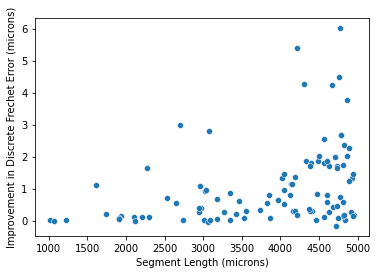

In [8]:
xs = [len_error[0] for len_error in len_errors]
ys = [len_error[1]-len_error[2] for len_error in len_errors]
data = {"Segment Length (microns)": xs, "Improvement in Discrete Frechet Error (microns)": ys}
df = pd.DataFrame(data=data)

sns.scatterplot(data=df, x="Segment Length (microns)", y="Improvement in Discrete Frechet Error (microns)")
#plt.scatter(xs,ys)
